# 0. Prepare data


In [7]:
import stlearn as st
import pandas as pd
# read in visium dataset downloaded from: support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Breast_Cancer_Block_A_Section_1
data = st.read.file_10x_mtx("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\filtered_feature_bc_matrix")
data.var_names_make_unique()

# 1. Add image, coordinates, and significant Ligand-Receptors from CPDB

In [8]:
st.add.image(adata=data, imgpath="C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\spatial\\tissue_lowres_image.png")
st.add.positions(data,position_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\spatial\\tissue_positions_list.csv",
                        scale_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\spatial\\scalefactors_json.json",
                        quality = "low")
st.add.cpdb(adata=data, cpdb_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\cpdb\\means.txt", sep="\t")


Trying to set attribute `.uns` of view, making a copy.


Added tissue image to the object!
Added cpdb results to the object!


AnnData object with n_obs × n_vars = 3813 × 33538 
    obs: 'imagerow', 'imagecol'
    var: 'gene_ids', 'feature_types'
    uns: 'tissue_img', 'cpdb'

# 2 Preprocessing

### 2.1. filter, normalize, scale & PCA

In [9]:
st.pp.filter_genes(data,min_cells=0.01*data.n_vars)
st.pp.normalize_total(data)
data.obsm['normalized'] = pd.DataFrame(data.X.toarray(), index=data.obs_names, columns=data.var_names)
st.pp.log1p(data)
st.pp.scale(data)
st.em.run_pca(data,n_comps=50)

filtered out 21848 genes that are detected in less than 335.38 cells
normalizing counts per cell
Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


### 2.2. add morphology information

In [4]:
st.pp.tiling(data,out_path="./temp_tiling",crop_size=40)
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data='X_pca',radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')

Tiling image: 100%|███████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Extract feature: 100%|████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|█████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


# 3. Cell-cell interaction analysis

### 3.1 Cell type heterogeneity

In [5]:
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


In [6]:
st.tl.clustering.louvain(data)

Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']


#### Count the density of cell types in user defined number of windows (e.g. num=30 means 30x30 windows across the tissue)

In [7]:
counts = st.tl.cci.het.count(data, num=30)

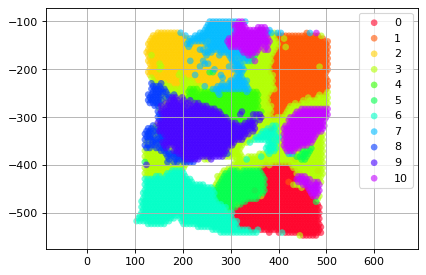

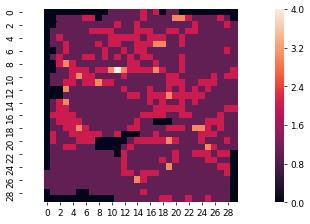

In [8]:
st.pl.het_plot(data, use_cluster='louvain', het=counts, dpi=80)

### 3.2 Cell-cell interaction based on spatial Ligand-Receptor (L-R) expression

#### label transfer from a published breast cancer dataset for all spots

In [10]:
data.obs['predictions'] = pd.read_csv('predictions.csv', sep='\t')

#### plot the transferred labels for each spot

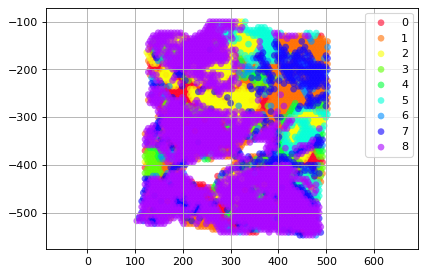

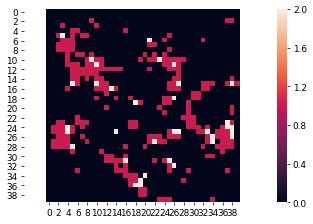

In [11]:
counts = st.tl.cci.het.count(data, use_clustering='predictions', use_clusters=['Bcell', 'Tcell', 'macrophage'], num=40)
st.pl.het_plot(data, use_cluster='predictions', het=counts, dpi=80)

#### cluster spatial spots based on the proportion of known ligand-receptor co-expression among the neighbouring spots

In [11]:
st.add.lr(data)
st.tl.cci.base.lr(adata=data, use_data='normalized', threshold=1, distance=10)

Added ligand receptor pairs to adata.uns['lr'].
Altogether 412 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata['lr_neighbours']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']
Spatial distribution of LR co-expression is written to adata.obsm['lr_neighbours']
Result of LR-clustering is kept in adata.obs['lr_neighbours_louvain']
The largest expressed LR neighbouring cluster is:  5


AnnData object with n_obs × n_vars = 3813 × 11690 
    obs: 'imagerow', 'imagecol', 'sum_counts', 'tile_path', 'louvain', 'predictions', 'lr_neighbours_louvain'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'tissue_img', 'cpdb', 'log1p', 'pca', 'neighbors', 'louvain', 'lr', 'lr_neighbours_louvain_max'
    obsm: 'filtered_counts', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology', 'lr_neighbours'
    varm: 'PCs'

#### plot the CCI clustering results and highlight the largest expressed cluster

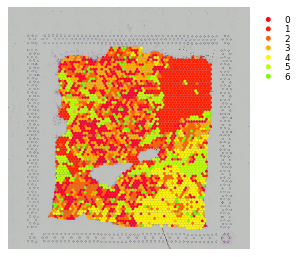

In [12]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain", dpi=80)

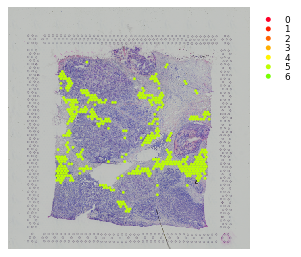

In [13]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain",list_cluster=[data.uns['lr_neighbours_louvain_max']], dpi=80)

#### Compare the immune cells identified by the label transfer and the CCI clustering

In [14]:
immune_cci = data.obs['lr_neighbours_louvain'].copy()
immune_cci = immune_cci.cat.set_categories(immune_cci.cat.categories.tolist()+['immune','non-immune'])
immune_cci[immune_cci!=data.uns['lr_neighbours_louvain_max']] = 'non-immune'
immune_cci[immune_cci==data.uns['lr_neighbours_louvain_max']] = 'immune'

immune_label = data.obs['predictions'].copy()
immune_label[immune_label.isin(['Bcell', 'Tcell', 'macrophage'])] = 'immune'
immune_label[immune_label!='immune'] = 'non-immune'

from sklearn.metrics.cluster import adjusted_rand_score
print(adjusted_rand_score(immune_cci, immune_label))

0.4043270890677005


#### List the top 15 differentiated L-R pairs in all CCI clusters

In [15]:
import scanpy as sc
from anndata import AnnData
rank_test = AnnData(data.obsm['lr_neighbours'])
rank_test.obs['lr_neighbours_louvain'] = data.obs['lr_neighbours_louvain']
sc.tl.rank_genes_groups(rank_test, 'lr_neighbours_louvain', method='t-test')
pd.DataFrame(rank_test.uns['rank_genes_groups']['names']).iloc[0:15,]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,0,1,2,3,4,5,6
0,LGALS9_DAG1,CCL5_ACKR1,CD74_COPA,SORT1_COPA,CEACAM6_CEACAM6,LRP1_LGALS9,LAMP1_FAM3C
1,DAG1_LGALS9,ACKR1_CCL5,COPA_CD74,COPA_SORT1,CEACAM6_CEACAM6,LGALS9_LRP1,FAM3C_LAMP1
2,LGALS9_SLC1A5,CCL2_ACKR1,CD74_APP,GRN_SORT1,COPA_CD74,LRP1_MDK,FAM3C_HLA-C
3,SLC1A5_LGALS9,ACKR1_CCL2,APP_CD74,SORT1_GRN,CD74_COPA,MDK_LRP1,HLA-C_FAM3C
4,LGALS9_CD47,ESAM_ESAM,CD74_MIF,CD74_COPA,SPP1_CD44,CXCR4_CXCL12,MIF_CD74
5,CD47_LGALS9,ESAM_ESAM,MIF_CD74,COPA_CD74,CD44_SPP1,CXCL12_CXCR4,CD74_MIF
6,CD44_LGALS9,PGF_NRP2,TNFRSF1A_GRN,APP_CD74,CD74_MIF,TNFRSF1B_GRN,CD74_COPA
7,LGALS9_CD44,NRP2_PGF,GRN_TNFRSF1A,CD74_APP,MIF_CD74,GRN_TNFRSF1B,COPA_CD74
8,LGALS9_COLEC12,PDGFRA_PDGFA,DSG2_DSC2,CD74_MIF,TNFRSF1A_GRN,LGALS9_CD44,FAM3C_CLEC2D
9,COLEC12_LGALS9,PDGFA_PDGFRA,DSC2_DSG2,MIF_CD74,GRN_TNFRSF1A,CD44_LGALS9,CLEC2D_FAM3C


#### Violin plot of top differentiated L-R pairs neighbouring counts in each CCI cluster

C:\Users\uqjxu8\GIH\Github\stLearn\stlearn\plotting\cci_plot.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violin['cci_cluster'] = adata.obs['lr_neighbours_' + use_cluster]


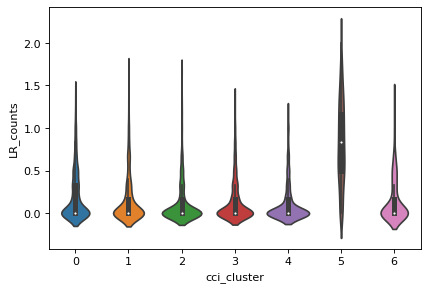

In [16]:
st.pl.violin_plot(data, lr='CXCR4_CXCL12', use_cluster='louvain', dpi=80)

#### barplot to show the cell type (according to label transfer) compositions in each CCI cluster

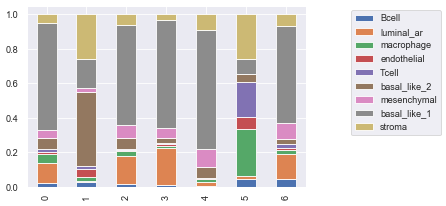

In [17]:
st.pl.stacked_bar_plot(data, use_annotation='predictions', dpi=60)

#### L-R expression summary across all spots

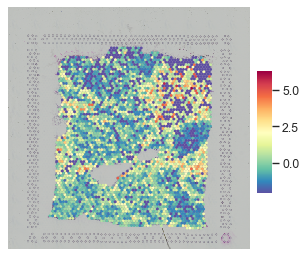

In [18]:
st.pl.gene_plot(data, genes=['LGALS9','LRP1'], method="CumSum", dpi=80)

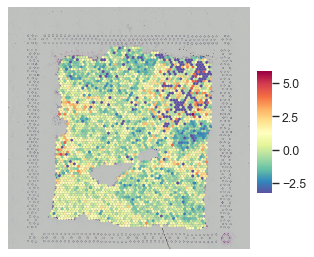

In [19]:
st.pl.gene_plot(data, genes=['MDK','LRP1'], method="CumSum", dpi=80)

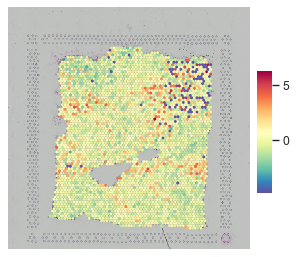

In [20]:
st.pl.gene_plot(data, genes=['TNFRSF1B','GRN'], method="CumSum", dpi=80)